For this notebook I will be following a blog titled, "A Gentle Introduction to Particle Swarm Optimization"

Link: https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/

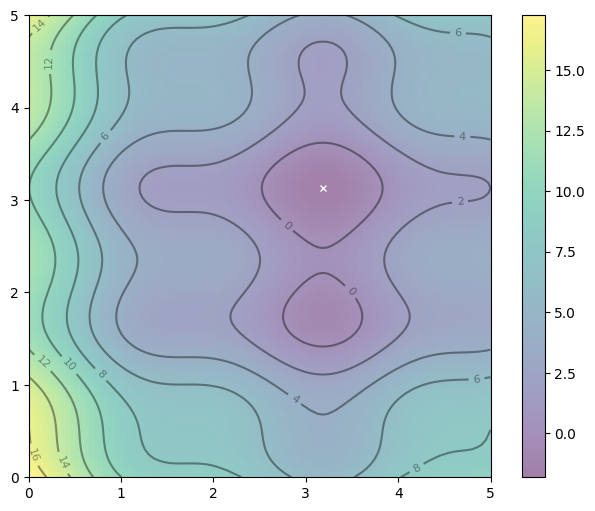

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def f(x, y):
    """ Objective Function """
    return (x - 3.14)**2 + (y - 2.72)**2 + np.sin(3 * x + 1.41) + np.sin(4 * y - 1.73)

# Compute and plot the function in 3D within [0,5]x[0,5]
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)

# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]

# Contour plot: With the global minimum showed as "X" on the plot
plt.figure(figsize=(8, 6))
plt.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color='white')
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt='%.0f')
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


PSO found best solution as f([3.18541756 3.12972478])=-1.8083516042208303
Global optimal at f([3.1818181818181817, 3.131313131313131])=-1.8082706615747688


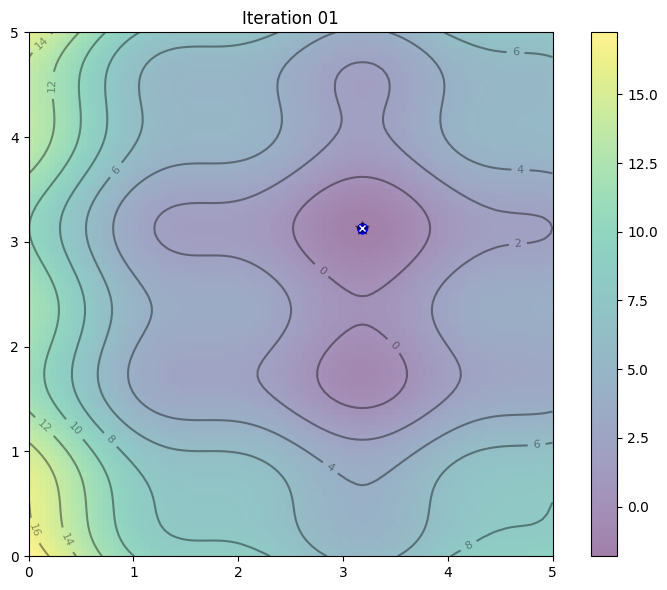

In [4]:
# Hyper-parameter of the algorithm
c1 = c2 = 0.1
w = 0.8

# Create particles
n_particles = 20
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1

# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

def update():
    """Function to do one iteration of particle swarm optimization"""
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1) - X)
    X = X + V
    obj = f(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()

# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color='white')
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt='%.0f')
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([0,5])
ax.set_ylim([0,5])

def animate(i):
    """Steps of PSO: algorithm update and show in plot"""
    title = 'Iteration {:02d}'.format(i)
    # Update params
    update()
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1, -1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot

anim = FuncAnimation(fig, animate, frames=list(range(1,50)), interval=500, blit=False, repeat=True)
anim.save("PSO.gif", dpi=120, writer="imagemagick")

print("PSO found best solution as f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min, y_min], f(x_min, y_min)))


This next section will be from a medium article titled, "Complete step by step particle swarm optimization algorithm from scratch"

Link: https://towardsdatascience.com/complete-step-by-step-particle-swarm-optimization-algorithm-from-scratch-74471d064f91


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def x3d(t, params):
    """Designed function for x3"""
    N = params.shape[-1]
    trig_array = [0] * N
    for i in range(N):
        n = (i + 1) // 2
        if i == 0:
            trig_array[i] = np.ones(len(t))
        elif i % 2 == 1:
            trig_array[i] = np.sin(n * t)
        else:
            trig_array[i] = np.cos(n * t)
    return np.dot(params, trig_array)

In [3]:
def x3dprime(t, params):
    """First derivate of x3d"""
    N = params.shape[-1]
    trig_array = [0] * N
    for i in range(N):
        n = (i + 1) // 2
        if i == 0:
            trig_array[i] = np.zeros(len(t))
        elif i % 2 == 1:
            trig_array[i] = n * np.cos(n * t)
        else:
            trig_array[i] = n * -np.sin(n * t)
    return np.dot(params, trig_array)

In [4]:
def obj(t, params):
    """Objective function to be minimized"""
    wder_min_w = (- x3dprime(np.array([0]), params) + x3d(np.array([0]), params)) * np.exp(-t)
    x1 = wder_min_w + x3dprime(t, params) - x3d(t, params)
    diff = np.abs(x1 - np.sin(t))
    error = 0
    for i in range(diff.shape[1] - 1):
        error += (diff[:,i+1] + diff[:,i]) * (t[i+1] - t[i]) / 2
    return error

In [5]:
def PSO(obj, p_num, N, scale, w=1, r=0.99, c1=1, c2=1, eps=1e-5,
        early_stopping=100, max_iter=1000, verbose=True, random_state=None):
    """ Main PSO Algorithm """

    # Initialize
    np.random.seed(random_state)
    params_num = 2 * N + 1
    p = np.random.normal(scale=scale, size=(p_num, params_num))
    v = np.random.normal(scale=scale, size=(p_num, params_num))
    t = np.linspace(0, 4 * np.pi, 101)
    error = obj(t, p)
    pbest = p.copy()
    gbest = p[error.argmin()]
    best_params = [gbest]
    e = [error.min()]
    iter_num = 0
    count = 0
    if verbose == True:
        if len(gbest) <= 7:
            print(f'Initial condition:  params = {gbest}\n\t\t     error = {e[-1]:.4f}\n')
        else:
            print(f'Initial condition:\terror = {e[-1]:.4f}\n')

    # main algorithm
    while error.min() > eps and iter_num < max_iter and count < early_stopping:
        # create random numbers, used for updating particle positions
        r1 = np.random.uniform(size=(params_num))
        r2 = np.random.uniform(size=(params_num))
        r1 = np.tile(r1, p_num).reshape(p_num, -1)
        r2 = np.tile(r2, p_num).reshape(p_num, -1)
        # update particle position
        v = w * v + c1 * r1 * (pbest - p) + c2 * r2 * (gbest - p)
        w = w * r 
        p = p + v
        # calculate error
        error = obj(t, p)
        errorbest = obj(t, pbest)
        # update global best
        gbest = p[error.argmin()]
        # update personal best
        min_idx = np.array([error, errorbest]).argmin(axis=0)
        for i, idx in enumerate(min_idx):
            if idx == 0: pbest[i,:] = p[i,:].copy()
        # update tabulation
        iter_num += 1
        if error.min() >= e[-1]:
            count += 1
        else:
            count = 0
        e.append(error.min())
        best_params.append(gbest)
        # print result in terminal
        if verbose:
            if len(gbest) <= 7:
                print(f'Iteration: {iter_num}\tbest params = {gbest}\n\t\terror = {e[-1]:.4f}')
            else:
                print(f'Iteration: {iter_num}\terror = {e[-1]:.4f}')
    
    # in case max iteration reached
    if iter_num == max_iter:
        print(iter_num, 'maximum iterations reached!',
              'Try increasing max_iter or adjusting PSO parameters for better result.')
        
    # cut tabulation for early stopping
    if count == early_stopping:
        iter_num = iter_num - count
        best_params = best_params[:-early_stopping]
        e = e[:-early_stopping]

    # return the number of iterations needed, the best parameters, and error
    return iter_num, np.array(best_params), np.array(e)

Initial condition:  params = [ 0.09495541 -0.1484898  -0.25539211  0.09343199 -0.13668787 -0.02247654
 -0.1170113 ]
		     error = 5.1687

Iteration: 1	best params = [ 0.0927755  -0.21362726 -0.27093549  0.03259867 -0.07809236 -0.06604722
 -0.05491775]
		error = 4.0092
Iteration: 2	best params = [ 0.05924213 -0.60831061 -0.44058426  0.00973174 -0.1110429  -0.10339552
  0.00466473]
		error = 3.6121
Iteration: 3	best params = [ 0.03633298 -0.41886206 -0.51639705  0.01121816 -0.02136765  0.01099861
  0.02811054]
		error = 1.2643
Iteration: 4	best params = [ 0.02228551 -0.44441899 -0.56194997 -0.02799135 -0.00318641  0.04019016
 -0.01437692]
		error = 1.2772
Iteration: 5	best params = [-0.02058441 -0.48073809 -0.75248233 -0.05540162 -0.03671896  0.00695582
 -0.0454124 ]
		error = 2.7673
Iteration: 6	best params = [-0.01643002 -0.58378026 -0.62955889  0.01268006  0.02813037  0.02213365
 -0.02471005]
		error = 1.9027
Iteration: 7	best params = [-0.04396211 -0.49502018 -0.57084917 -0.01385304

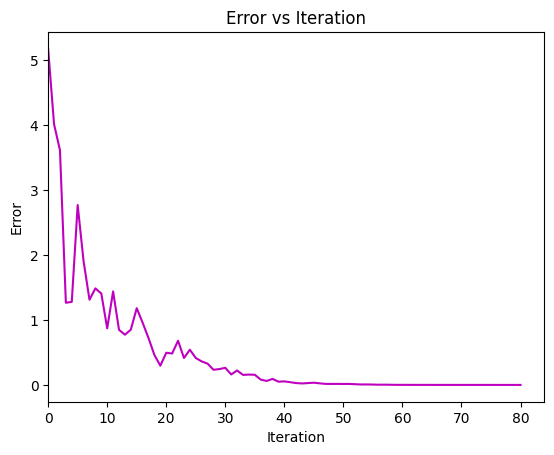

In [6]:
k, best_params, error = PSO(obj, p_num=800, N=3, scale=0.1, random_state=42)
plt.plot(error, c='m')
plt.title('Error vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.xlim(0)
plt.show()

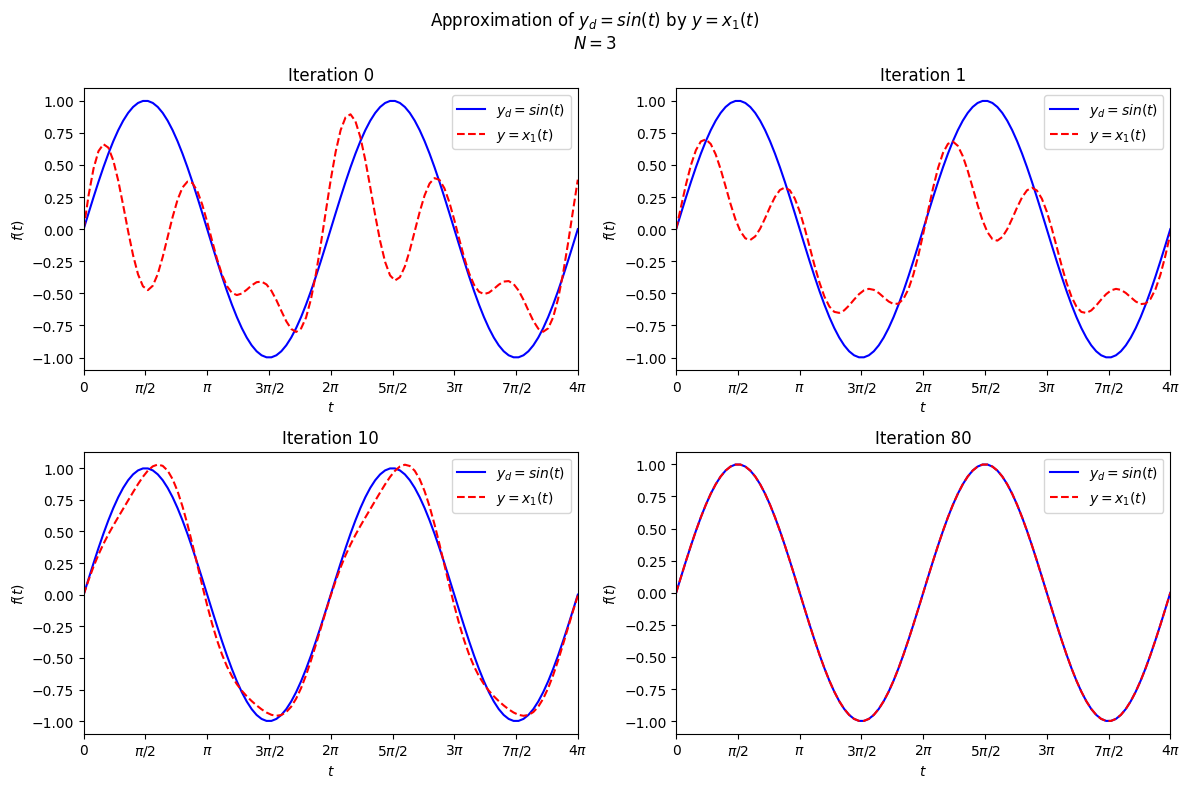

In [7]:
from basic_units import radians

def sin(x):
    if np.iterable(x):
        return [np.sin(val.convert_to(radians).get_value()) for val in x]
    else:
        return np.sin(x.convert_to(radians).get_value())
    
def plot_result(k, best_params, N):
    t = np.linspace(0, 4 * np.pi, 101)
    x = t * radians
    plt.figure(figsize=(12,8))
    iter_choice = [0, k // 64, k // 8, k]
    for ax, i in enumerate(iter_choice):
        p = best_params[i]
        wder_min_w = (- x3dprime(np.array([0]), p) + x3d(np.array([0]), p)) * np.exp(-t)
        x1 = wder_min_w + x3dprime(t, p) - x3d(t, p)
        plt.subplot(2, 2, ax+1)
        plt.plot(x, sin(x), 'b', xunits=radians)
        plt.plot(x, x1, 'r--', xunits=radians)
        plt.title(f'Iteration {i}')
        plt.xlabel('$t$')
        plt.ylabel('$f(t)$')
        plt.xlim(0, 4 * np.pi)
        plt.legend(['$y_d = sin(t)$', '$y = x_1(t)$'], loc='upper right')

    plt.suptitle(f'Approximation of $y_d = sin(t)$ by $y = x_1(t)$\n$N = {N}$')
    plt.tight_layout()
    plt.show()

plot_result(k, best_params, 3)

In [8]:
def plot_average_result(param, N):
    t = np.linspace(0, 4 * np.pi, 101)
    x = t * radians

    p = param.mean(axis=0)
    wder_min_w = (- x3dprime(np.array([0]), p) - x3d(np.array([0]), p)) * np.exp(-t)
    x1 = wder_min_w + x3dprime(t, p) - x3d(t, p)

    plt.plot(x, sin(x), 'b', xunits=radians)
    plt.plot(x, x1, 'r--', xunits=radians)
    plt.title(f'Average Approximation after Running {len(param)} Times\n$N = {N}$')
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')
    plt.xlim(0, 4 * np.pi)
    plt.legend(['$y_d = sin(t)$', '$y = x_1(t)$'], loc='upper right')
    plt.show()

trials = 100

Average number of iterations: 78.23
Average parameters found    : [-1.96148263e-08 -5.00000024e-01 -4.99999977e-01  8.69648213e-09
  1.59648819e-08 -2.74475805e-09 -2.00850658e-09]
Average errors              : 4.663474179409876e-07


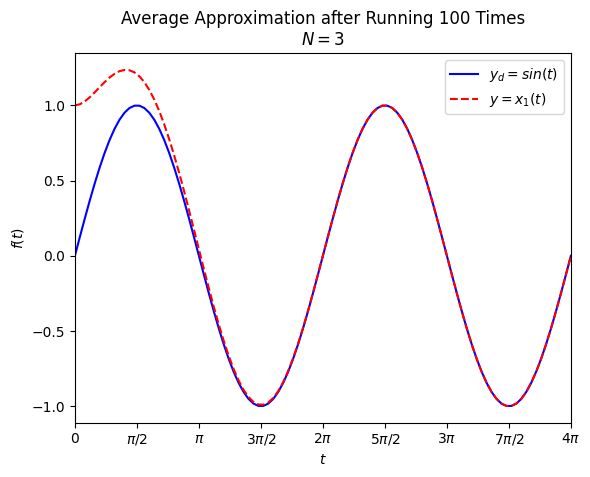

In [9]:
# Case 1: N = 3 and scaling = 0.10

ks = np.zeros(trials)
best = np.zeros((trials, 7))
errors = np.zeros(trials)
for i in range(trials):
    k, best_params, error = PSO(obj, p_num=800, N=3, scale=0.1, verbose=False, random_state=i)
    ks[i] = k
    best[i] = best_params[-1]
    errors[i] = error[-1]

t = np.linspace(0, 4 * np.pi, 101)
p = best.mean(axis=0)
print(f'Average number of iterations: {np.array(ks).mean()}')
print(f'Average parameters found    : {p}')
print(f'Average errors              : {obj(t, p.reshape(1, -1)).item(0)}')
plot_average_result(best, 3)

Average number of iterations: 159.06
Average parameters found    : [ 2.77669888e-04 -5.00028298e-01 -4.99962314e-01 -2.07214623e-05
  1.35488131e-04 -8.17892383e-05  3.02623358e-05  2.21678019e-05
  1.48189366e-05 -1.27103542e-06  1.01399954e-05 -1.00090756e-05
 -1.85610973e-06]
Average errors              : 0.0033187883813978764


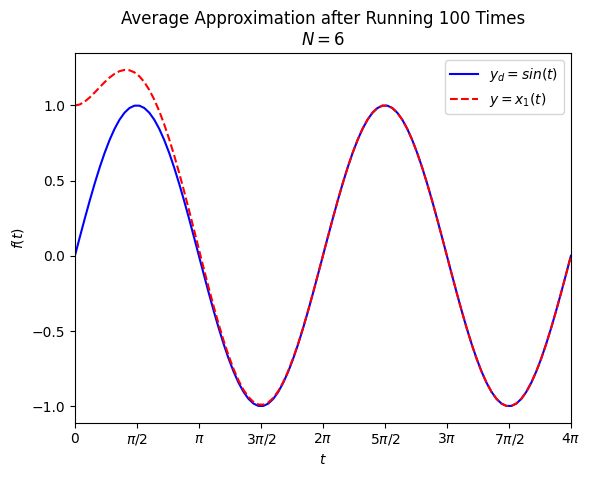

In [10]:
# Case 2: N = 6 and scaling = 0.03

ks = np.zeros(trials)
best = np.zeros((trials, 13))
errors = np.zeros(trials)
for i in range(100):
    k, best_params, error = PSO(obj, p_num=800, N=6, scale=0.03, verbose=False, random_state=i)
    ks[i] = k
    best[i] = best_params[-1]
    errors[i] = error[-1]

t = np.linspace(0, 4 * np.pi, 101)
p = best.mean(axis=0)
print(f'Average number of iterations: {np.array(ks).mean()}')
print(f'Average parameters found    : {p}')
print(f'Average errors              : {obj(t, p.reshape(1, -1)).item(0)}')
plot_average_result(best, 6)

Average number of iterations: 146.13
Average parameters found    : [ 4.55563980e-03 -4.53506047e-01 -4.53934515e-01 -2.52215947e-03
  2.95561938e-03 -9.53175210e-03 -8.68905939e-03  1.19820265e-03
  1.13060532e-03  1.56860675e-03  3.82793788e-03 -2.15951133e-03
  8.62882501e-04 -8.92462522e-04  4.55403183e-04  1.16895652e-03
  8.28995661e-04 -1.89711960e-04  7.16153581e-04 -8.82672291e-04
  6.64216547e-04  1.19732155e-04  1.77110052e-04 -1.02479777e-04
 -1.90013119e-04]
Average errors              : 0.6630980162922211


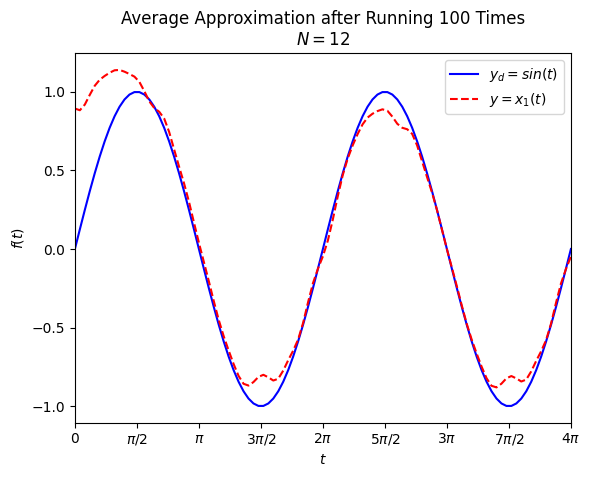

In [11]:
# Case N = 12 and scaling = 0.01

ks = np.zeros(trials)
best = np.zeros((trials, 25))
errors = np.zeros(trials)
for i in range(100):
    k, best_params, error = PSO(obj, p_num=800, N=12, scale=0.01, verbose=False, random_state=i)
    ks[i] = k
    best[i] = best_params[-1]
    errors[i] = error[-1]

t = np.linspace(0, 4 * np.pi, 101)
p = best.mean(axis=0)
print(f'Average number of iterations: {np.array(ks).mean()}')
print(f'Average parameters found    : {p}')
print(f'Average errors              : {obj(t, p.reshape(1, -1)).item(0)}')
plot_average_result(best, 12)